In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
working_dir = 'C:/Users/palmiteradmin/Documents/GitHub/MPNeuro/Ethovision/'
NUM_MICE = 3
import MPNeuro.plotting as MP_plot

In [2]:
import matplotlib as mpl
%matplotlib inline
mpl.rc('font', size=20)
mpl.rc('lines', linewidth=3)

In [3]:
def load_rtpp_csv(csv_name):
    col_names = ['a', 'b', 'time', 'freq', 'hungry', 'mouse_id', 'distance', 'stim_time', 'other_time', 'middle_time', 'c']
    df = pd.read_csv(working_dir + csv_name, delimiter=';', encoding='utf-16', skiprows=3)
    df.columns = col_names
    df.drop(['a', 'b', 'c'], axis=1, inplace=True)
    return df

In [4]:
bin_min = 10 # ten minute bins
five_sated_df = load_rtpp_csv('160302 - RTPP - 5Hz sated.csv')
five_sated_df2 = load_rtpp_csv('160310 - RTPP - 5Hz sated.csv')
five_hungry_df = load_rtpp_csv('160304 - RTPP - 5Hz hungry.csv')
forty_sated_df = load_rtpp_csv('160307 - RTPP - 40Hz sated.csv')
forty_hungry_df = load_rtpp_csv('160309 - RTPP - 40Hz hungry.csv')

In [5]:
def calc_mean_ste(df, col = 'time'):
    mean = df.groupby(col).mean() / 60 / bin_min
    ste = df.groupby(col).mean() / 60 / bin_min / np.sqrt(NUM_MICE)
    return [mean.reindex(['Start-0:10:00', '0:10:00-0:20:00', '0:20:00-0:30:00']),
            ste.reindex(['Start-0:10:00', '0:10:00-0:20:00', '0:20:00-0:30:00'])]
[five_sated_mean, five_sated_ste] = calc_mean_ste(five_sated_df)
[five_sated_mean2, five_sated_ste2] = calc_mean_ste(five_sated_df2)
[five_hungry_mean, five_hungry_ste] = calc_mean_ste(five_hungry_df)
[forty_sated_mean, forty_sated_ste] = calc_mean_ste(forty_sated_df)
[forty_hungry_mean, forty_hungry_ste] = calc_mean_ste(forty_hungry_df)

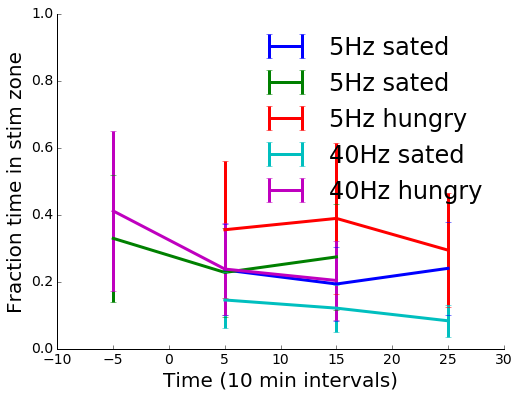

In [6]:
fig,ax = plt.subplots(1,1, figsize=[8,6])
x_indices = [5, 15, 25]
plt.errorbar(x_indices, five_sated_mean['stim_time'].values, five_sated_ste['stim_time'].values, label = '5Hz sated')
plt.errorbar(np.array(x_indices)-10, five_sated_mean2['stim_time'].values, five_sated_ste2['stim_time'].values, label = '5Hz sated')
plt.errorbar(x_indices, five_hungry_mean['stim_time'].values, five_hungry_ste['stim_time'].values, label = '5Hz hungry')
plt.errorbar(x_indices, forty_sated_mean['stim_time'].values, forty_sated_ste['stim_time'].values, label = '40Hz sated')
plt.errorbar(np.array(x_indices)-10, forty_hungry_mean['stim_time'].values, forty_hungry_ste['stim_time'].values, label = '40Hz hungry')
plt.ylim([0, 1])
plt.xlim([-10, 30])
plt.xlabel('Time (10 min intervals)')
plt.ylabel('Fraction time in stim zone')
plt.legend(frameon=False)
MP_plot.prettify_axes(ax)

In [7]:
forty_hungry_df

,time,freq,hungry,mouse_id,distance,stim_time,other_time,middle_time
0,Start-0:10:00,40,Hungry,MP132,2521.34,328.4000,105.933,163.067
1,0:10:00-0:20:00,40,Hungry,MP132,2250.54,136.7330,323.401,136.867
2,0:20:00-0:30:00,40,Hungry,MP132,2842.68,142.2670,301.065,151.402
3,Start-0:10:00,40,Hungry,MP133,2605.41,149.3330,218.800,222.400
4,0:10:00-0:20:00,40,Hungry,MP133,2370.88,111.5330,250.200,232.400
5,0:20:00-0:30:00,40,Hungry,MP133,2111.21,92.7332,329.135,168.799
6,Start-0:10:00,40,Hungry,MP134,3464.01,263.3340,139.467,190.733
7,0:10:00-0:20:00,40,Hungry,MP134,2944.04,180.3990,198.400,214.668
8,0:20:00-0:30:00,40,Hungry,MP134,2815.34,132.3330,298.268,165.065
